# Table of Contents

- [Initial Configuration](#Initial-Configuration)
- [Familiar Economy](#Familiar-Economy)
- [House and Air Conditionings](#House-and-Air-Conditionings)
- [Stock Control](#Stock-Control)
- [Useful life](#Useful-life)
- [Foxes and Rabbits](#Foxes-and-Rabbits)

# Initial Configuration

In [5]:
# General Purpose
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout, interactive, HBox, VBox

%matplotlib inline

style = {'description_width': '150px'}
slider_layout = Layout(width='99%')

In [6]:
plt.style.use('bmh')

In [7]:
import sympy as sy
from collections import namedtuple

fields = [
    "equilibrium_x",
    "equilibrium_y",
    "natural_frequency",
    "damping_ratio",
    "decay_rate",
]
AnalysisResults = namedtuple('AnalysisResults', fields)


def analyse(function):
    x, y = sy.symbols('x, y', positive=True)
    equations = sy.Matrix(function([x, y], 0))
    
    equilibrium_solutions = sy.solve(sy.Eq(equations, sy.Matrix([0, 0])), [x, y], dict=True)
    equilibrium_solutions = equilibrium_solutions[0] if len(equilibrium_solutions) else equilibrium_solutions
    x_equilibrium = equilibrium_solutions[x]
    y_equilibrium = equilibrium_solutions[y]
    
    jacobian = equations.jacobian([x, y])
    
    jacobian_at_equilibrium = jacobian.subs({x: x_equilibrium, y: y_equilibrium})
    
    eigenvalues = sy.Matrix(list(jacobian_at_equilibrium.eigenvals()))
    
    decay_rate = abs(sy.re(eigenvalues)[0])
    
    natural_frequency = abs(sy.im(eigenvalues)[0])
    
    damping_ratio = decay_rate / (decay_rate**2 + natural_frequency**2)**0.5
    
    return AnalysisResults(
        x_equilibrium,
        y_equilibrium,
        natural_frequency,
        damping_ratio,
        decay_rate
    )

In [8]:
import os
import pickle
import pprint
import time
from collections import defaultdict
from datetime import datetime

import pandas as pd
import sympy as sy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from IPython.display import clear_output

In [9]:
def round_expr(expr, num_digits=5):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sy.Number)})

In [10]:
def plot_vector_field(xs, ys, function, *, ax):
    X1 , Y1  = np.meshgrid(xs, ys)          # create a grid
    DX1, DY1 = function([X1, Y1], 0)        # compute growth rate on the grid
    M = np.hypot(DX1, DY1)                  # norm growth rate 
    M[ M == 0] = 1.                         # avoid zero division errors 
    DX1 /= M                                # normalize each arrows
    DY1 /= M
    M /= 2
    
    cmap = ListedColormap(sns.color_palette("Greens_r", 50)[:-20])
    ax.streamplot(X1, Y1, DX1, DY1, density=1.5, color=M, cmap=cmap)

In [181]:
def plot_normal_vectors(xs, ys, function, *, ax, skip=15, **kwargs):
    xs_, ys_ = xs[::skip], ys[::skip]
    
    dsdt = np.array(function([xs_, ys_], 0))
    norm = np.hypot(*dsdt) 

    if norm.any():
        dsdt /= norm

    ax.quiver(xs_, ys_, *dsdt, scale=kwargs.pop("scale"), scale_units="x", **kwargs)

In [170]:
def compute_nullclines(xs, delta, independent_variable, dependable_variable, *, invert=False):
    solution = sy.solve(sy.Eq(delta, 0), dict=True)
    
    nullcline_, *_ = solution
    nullcline = nullcline_.get(independent_variable)

    if not nullcline:
        dependable_nullcline = nullcline_.get(dependable_variable, nullcline)
        if nullcline != dependable_nullcline:
            invert = True
            
        nullcline = nullcline_.get(dependable_variable, nullcline)
    
    if not invert:
        evaluate = np.vectorize(sy.utilities.lambdify(dependable_variable, nullcline))
        ys = evaluate(xs)
        return xs, ys, nullcline
    
    if not nullcline or not nullcline.free_symbols:
        constant = float(nullcline)
        xs = np.ones_like(xs) * constant
        ys = np.linspace(0, constant * 2, 1000)
        return xs, ys, nullcline

    nullclines = sy.solve(nullcline - independent_variable, dependable_variable)
    nullcline = nullclines[0] if len(nullclines) else nullclines
    evaluate = np.vectorize(sy.utilities.lambdify(independent_variable, nullcline))
    ys = evaluate(xs)
    return xs, ys, nullcline
    
def plot_nullclines(xs, delta, independent_variable, dependable_variable, function, *, ax, invert=False, **kwargs):
    xs, ys, nullcline = compute_nullclines(xs, delta, independent_variable, dependable_variable, invert=invert)
    
    skip = kwargs.pop("skip")
    scale = kwargs.pop("scale")

    label = f"{dependable_variable}-Nullcline - $dx/dt=0 \Rightarrow f(x): {round_expr(nullcline)}$"
    ax.plot(xs, ys, label=label, ls="--", lw=2, **kwargs)

    plot_normal_vectors(xs, ys, function, ax=ax, skip=skip, scale=scale, color=kwargs.get("color"), width=.0025)

In [171]:
def plot_equilibrium(dsdt, first_variable, second_variable, *, ax):
    equilibrium = sy.solve(dsdt, first_variable, second_variable, dict=True)
    equilibrium = equilibrium[0] if len(equilibrium) else equilibrium
    first_fix_point = equilibrium[first_variable]
    second_fix_point = equilibrium[second_variable]
    
    label = f"Fix Point at $x={first_fix_point:2.2f}; y={second_fix_point:2.2f}$"
    ax.scatter(first_fix_point, second_fix_point, s=100, color="gold", ls="--", label=label)

In [172]:
def plot_field_and_nullclines(function, *, xlim=(0.01, 50), ylim=(0, 50), sample_size=1000, scale=0.75, x_skip=1, y_skip=1):
    xs = np.linspace(*xlim, sample_size)
    ys = np.linspace(*ylim, sample_size)
    
    x, y = sy.symbols('x, y', real=True)
    
    system_at_equilibrium = function([x, y], 0)
    x_at_equilibrium, y_at_equilibrium = system_at_equilibrium
    
    fig, ax = plt.subplots(figsize=(16, 5))
    
    plot_vector_field(xs, ys, function, ax=ax)
    
    plot_nullclines(xs, x_at_equilibrium, y, x, function, ax=ax, skip=x_skip, color="royalblue", scale=scale)
    
    plot_nullclines(xs, y_at_equilibrium, x, y, function, ax=ax, invert=True, skip=y_skip, color="firebrick", scale=scale)
    
    plot_equilibrium(system_at_equilibrium, x, y, ax=ax)
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    ax.legend(loc="upper left")
    
    plt.tight_layout()
    plt.show()

In [173]:
def compute_envelope(xs, initial_condition, equilibrium, initial_condition_delta, analysis_results):
    C1, C2, t = sy.symbols('C1 C2 t')

    exponential_decay = sy.exp(-analysis_results.decay_rate*t)
    periodic_oscillation = C1 * sy.cos(analysis_results.natural_frequency*t) + C2 * sy.sin(analysis_results.natural_frequency*t)
    offset = equilibrium
    general_solution_form = exponential_decay * periodic_oscillation + offset

    initial_condition_equation = sy.Eq(general_solution_form.subs(t, 0), initial_condition)

    C1_solution = float(sy.solve(initial_condition_equation, C1)[0])
    
    general_solution_first_derivative_at_initial_time = sy.diff(general_solution_form, t).subs(t, 0)

    C2_equation = sy.Eq(general_solution_first_derivative_at_initial_time, initial_condition_delta)

    C2_solution = float(sy.solve(C2_equation.subs(C1, C1_solution), C2)[0])

    amplitude = np.sqrt((C1_solution) ** 2 + (C2_solution) ** 2)
    
    envelope_exponential_decay = amplitude * np.exp(-xs * float(analysis_results.decay_rate))
    
    upper_envelop = offset + envelope_exponential_decay
    lower_envelop = offset - envelope_exponential_decay
    return upper_envelop, lower_envelop

# Autonomous Systems

In [182]:
def main(A, B, C, D, x_0, y_0, days):
    def function(S, time):
        x, y = S
        return [
            A * x + B * y,
            C * x + D * y
        ]

    p = A + D
    q = A * D - B * C
    delta = p ** 2 - 4 * q
    
    time = np.linspace(0, days, days*10)
    
    solution = odeint(function, [x_0, y_0], time)

    x_solution, y_solution = solution.T

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    ax = axes[0]

    
    ax.plot(time, x_solution, label='x(t)', color="royalblue")
    ax.plot(time, y_solution, label='y(t)', color="firebrick")

    
    handles, labels = ax.get_legend_handles_labels()
    proxy_artist = mpatches.Rectangle((0, 0), 1, 1, alpha=0)
    handles += [proxy_artist]
    labels += [f"$p={p:.2f}$"]

    proxy_artist = mpatches.Rectangle((0, 0), 1, 1, alpha=0)
    handles += [proxy_artist]
    labels += [f"$q={q:.2f}$"]

    proxy_artist = mpatches.Rectangle((0, 0), 1, 1, alpha=0)
    handles += [proxy_artist]
    labels += [f"$\Delta={delta:.2f}$"]
    
    ax.legend(handles, labels, loc='best')

    ax = axes[1]

    ax.plot(x_solution, y_solution, label='x vs y')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

    plot_field_and_nullclines(function, scale=2.5, xlim=(-5, 5), ylim=(-5, 5), x_skip=15, y_skip=3)


In [183]:
interact(
    main,
    A=FloatSlider(min=-5, max=5, step=0.1, value=0, description='A', style=style, layout=slider_layout),
    B=FloatSlider(min=-5, max=5, step=0.1, value=-1, description='B', style=style, layout=slider_layout),
    C=FloatSlider(min=-5, max=5, step=0.1, value=2, description='C', style=style, layout=slider_layout),
    D=FloatSlider(min=-5, max=5, step=0.1, value=-0.1, description='D', style=style, layout=slider_layout),
    x_0=FloatSlider(min=0, max=10, step=1, value=1, description='x_0', style=style, layout=slider_layout),
    y_0=FloatSlider(min=0, max=10, step=1, value=1, description='y_0', style=style, layout=slider_layout),
    days=IntSlider(min=1, max=360, step=10, value=101, description='t', style=style, layout=slider_layout),
);

interactive(children=(FloatSlider(value=0.0, description='A', layout=Layout(width='99%'), max=5.0, min=-5.0, s…

## Spiral Sink

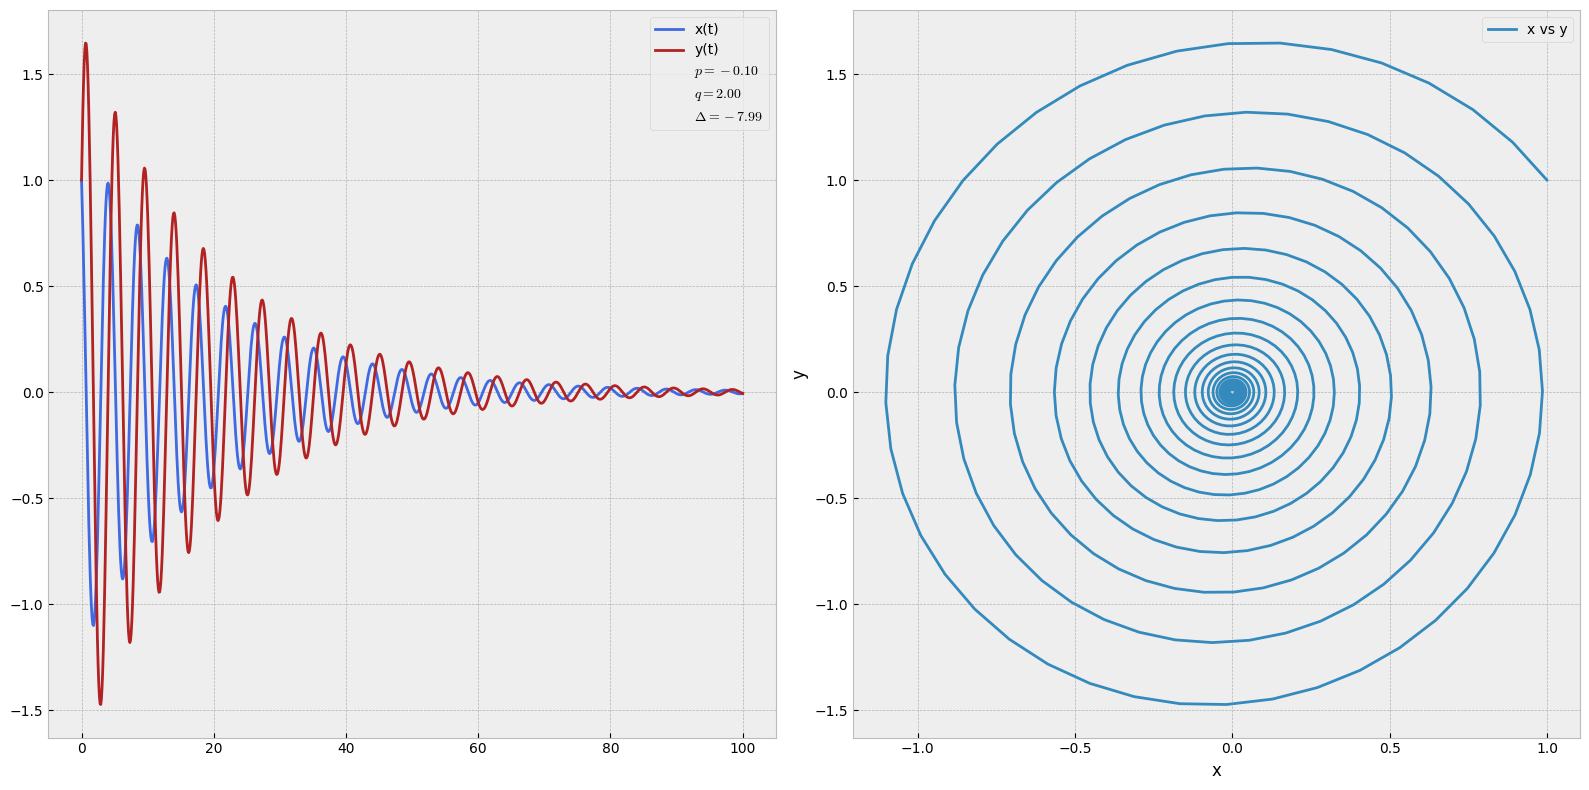

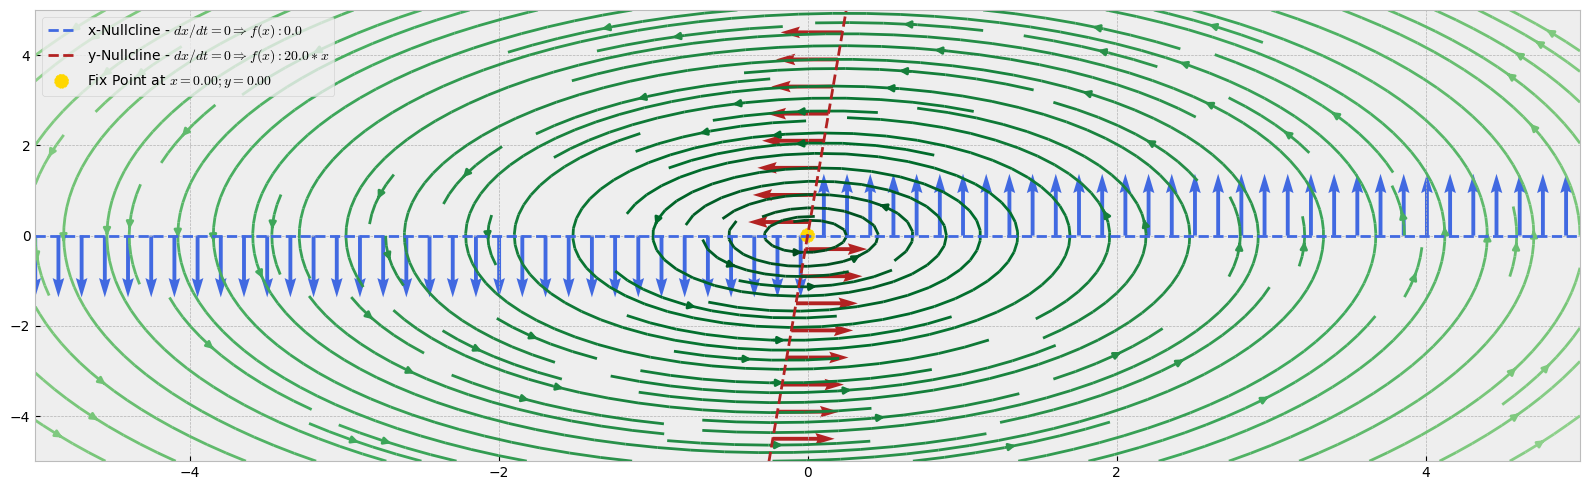

In [180]:
main(
    A=0,
    B=-1.00,
    C=2.00,
    D=-0.10,
    x_0=1,
    y_0=1,
    days=100,
);

## Center

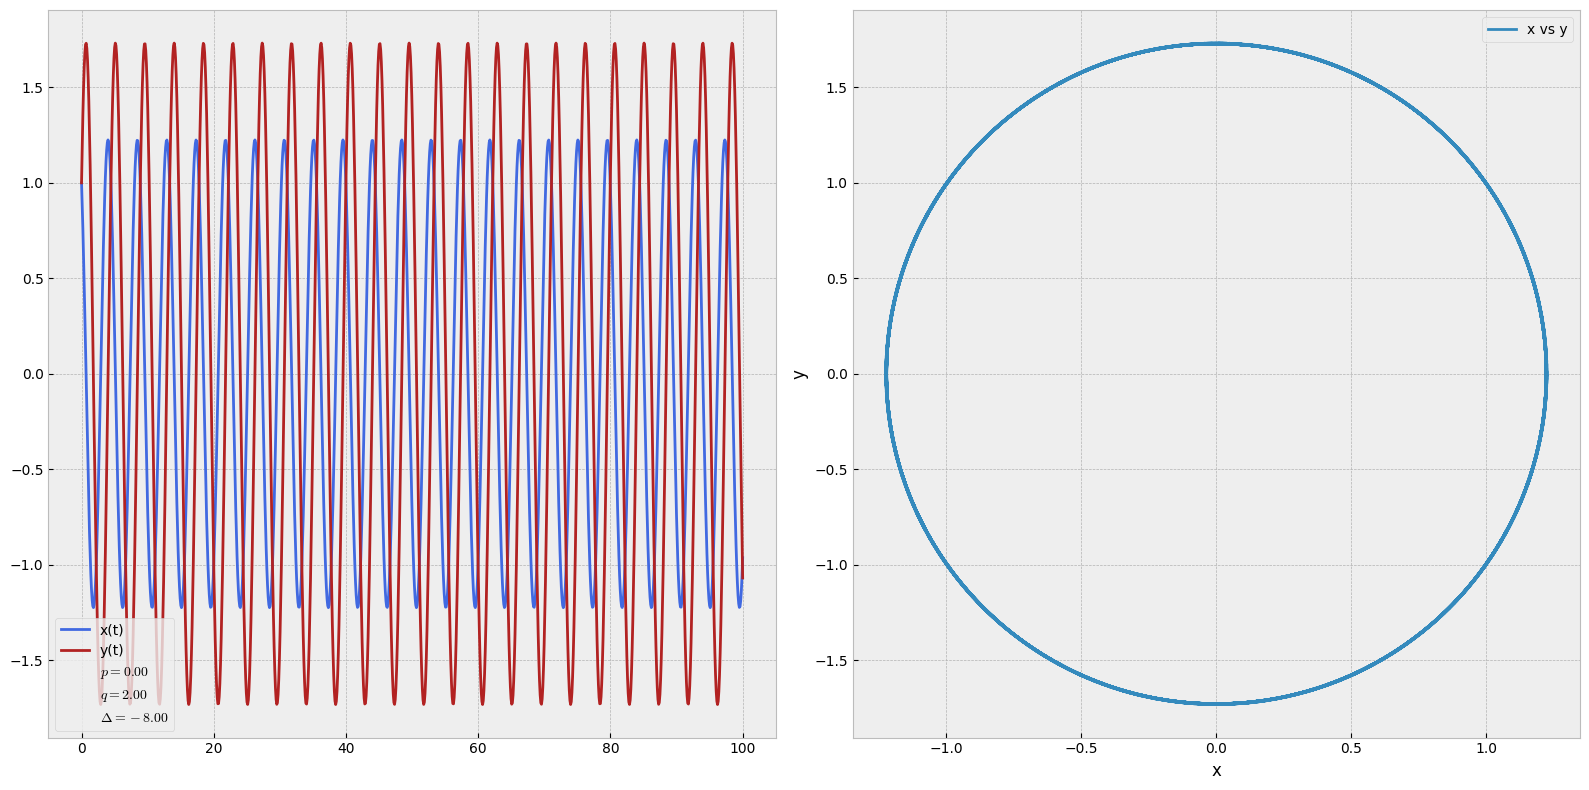

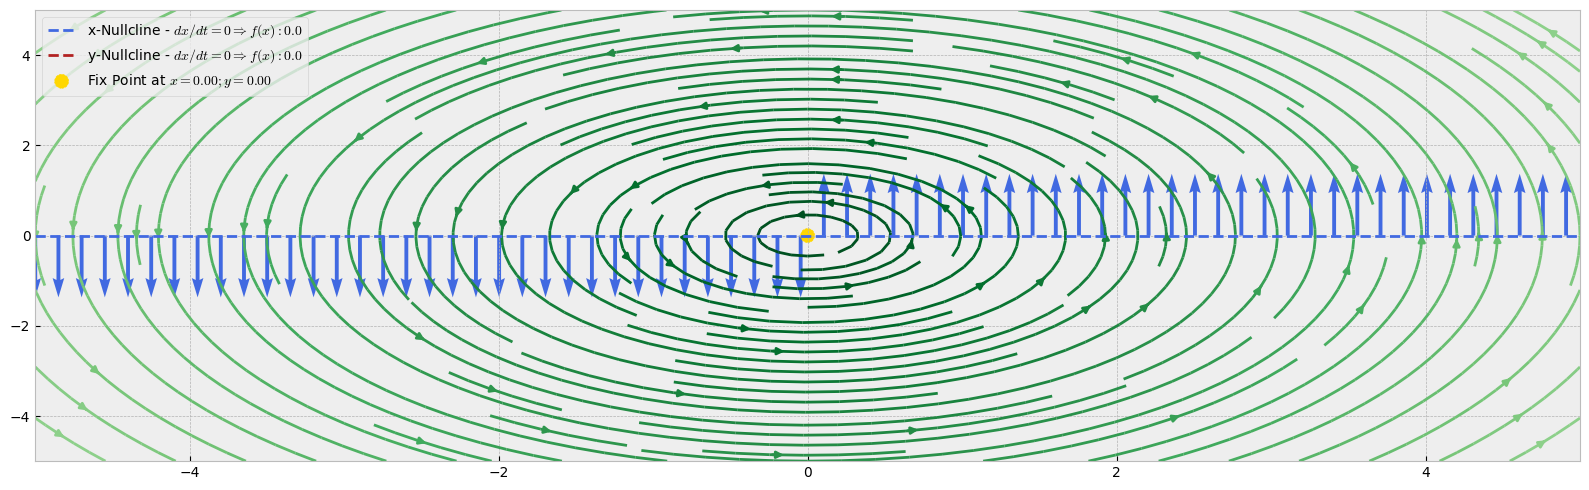

In [184]:
main(
    A=0,
    B=-1.00,
    C=2.00,
    D=0,
    x_0=1,
    y_0=1,
    days=100,
);

## Spiral Source

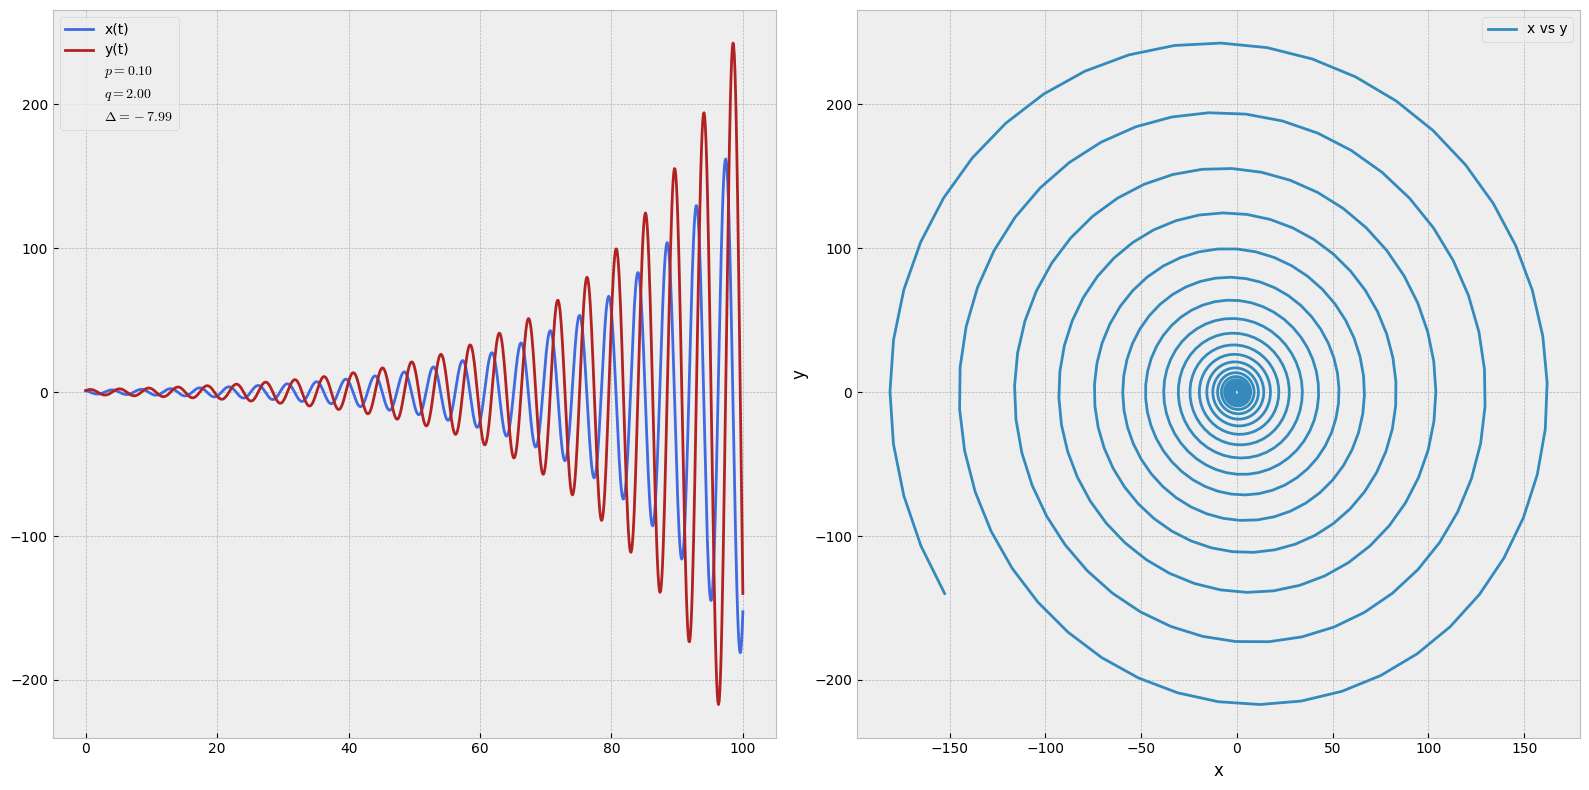

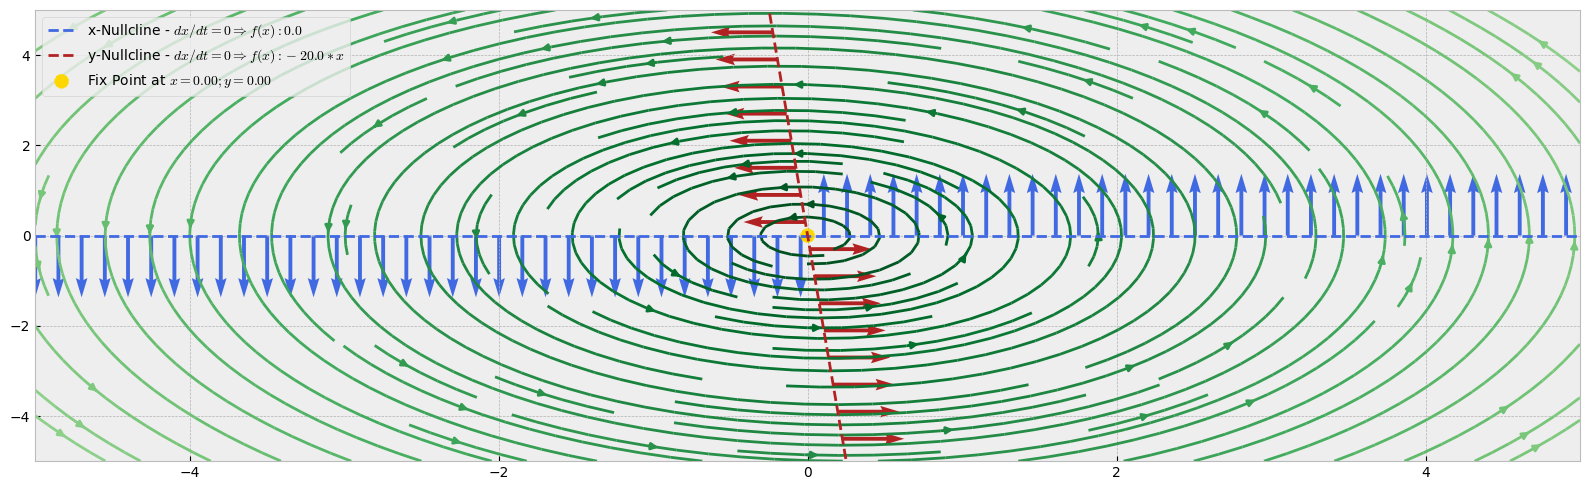

In [185]:
main(
    A=0,
    B=-1.00,
    C=2.00,
    D=0.10,
    x_0=1,
    y_0=1,
    days=100,
);

In [21]:
provider_delay = 10
market_demand = 10

### Underdamped

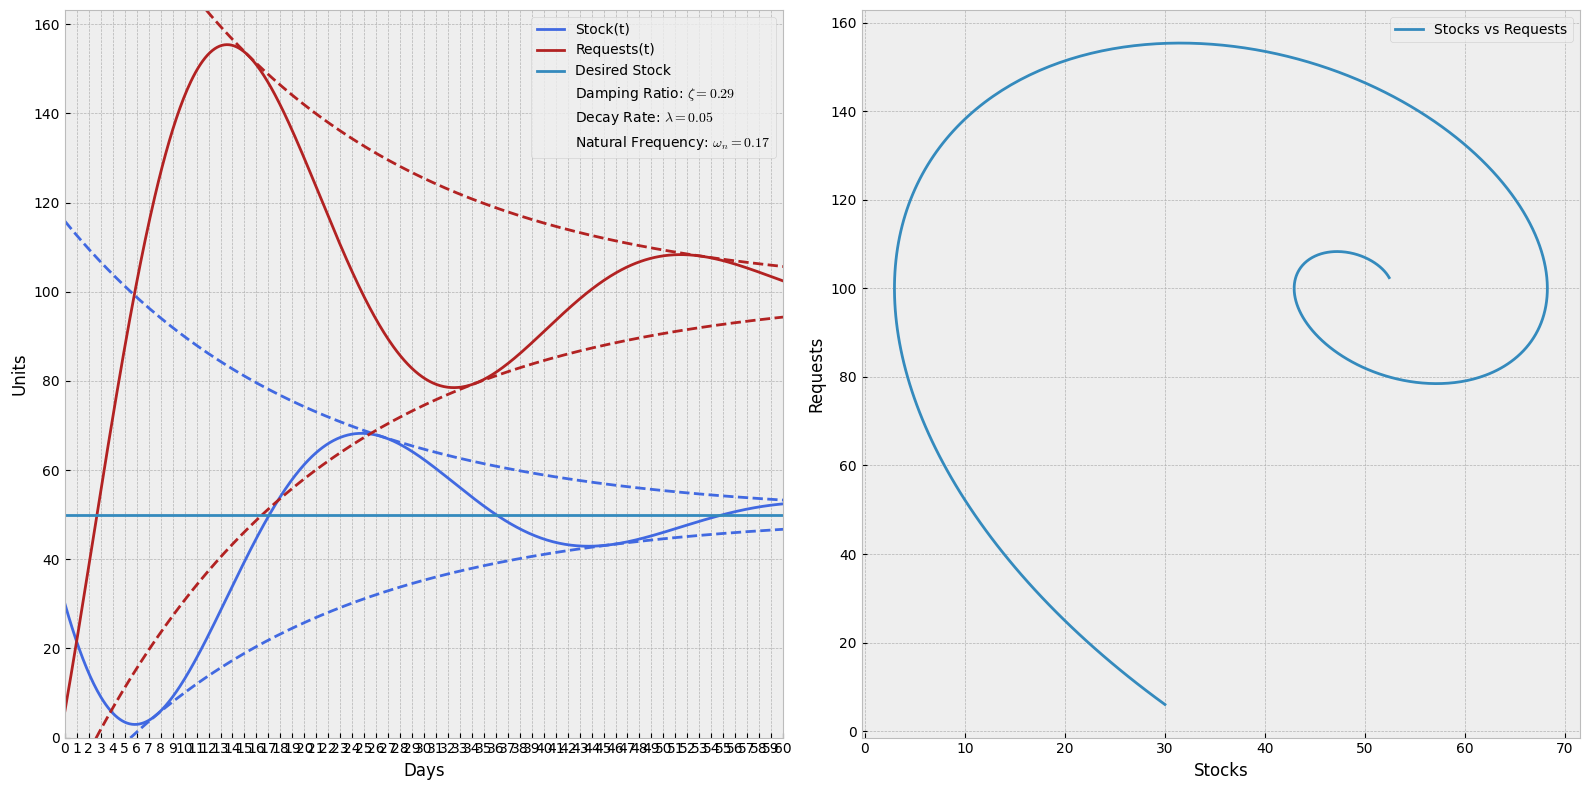

In [22]:
main(
    stock_control=0.3,
    provider_delay=provider_delay,
    desired_stock=50,
    market_demand=market_demand,
    initial_request=initial_request,
    initial_stock=30,
    days=days,
);

### Critically Damped

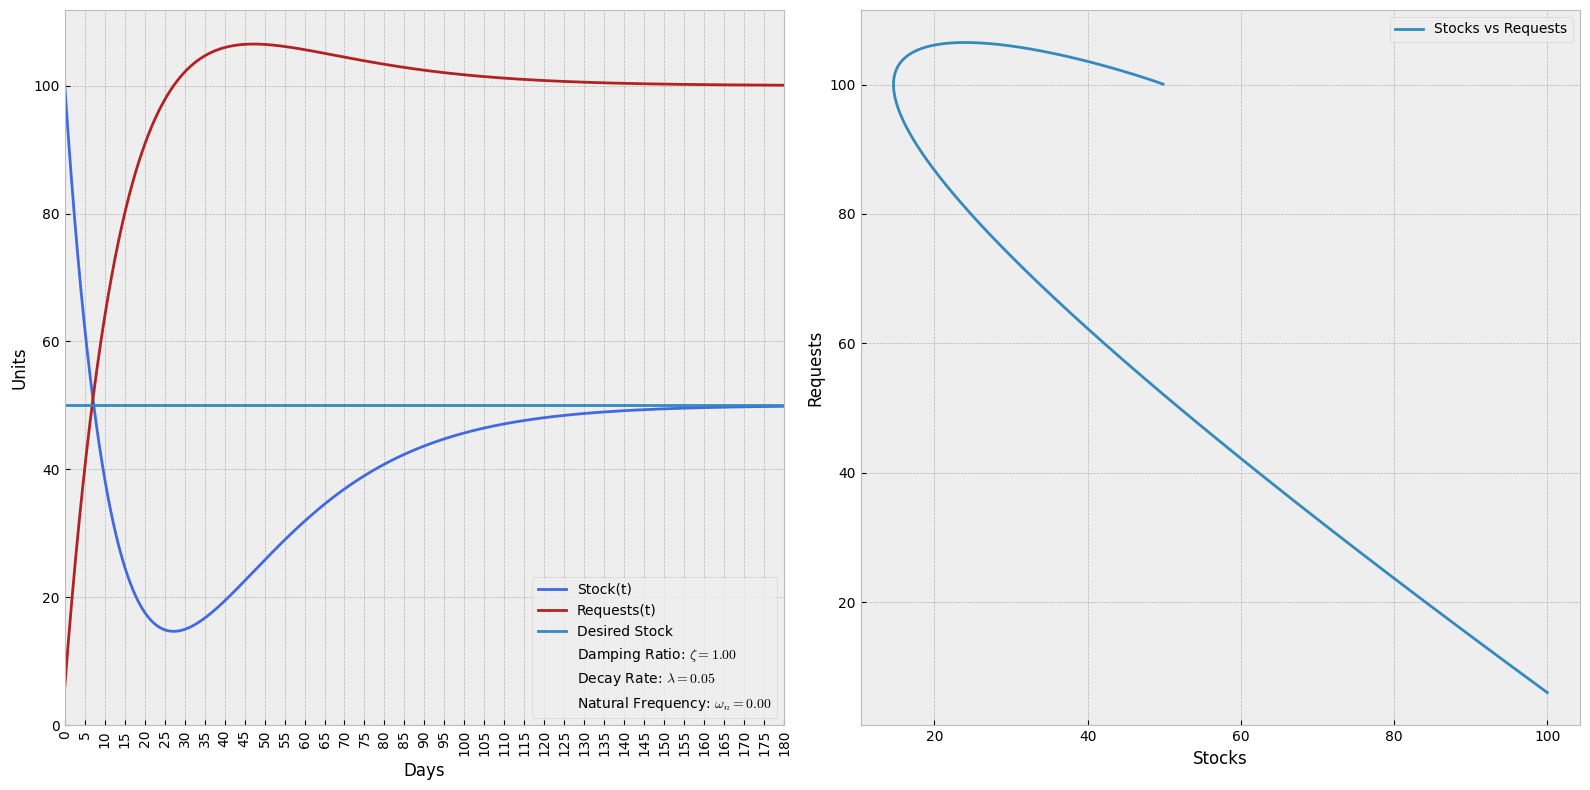

In [23]:
main(
    stock_control=0.025,
    provider_delay=provider_delay,
    desired_stock=50,
    market_demand=market_demand,
    initial_request=initial_request,
    initial_stock=100,
    days=days*3,
);

### Automatic Computation

In [24]:
def safe_solve(equation: sy.Eq, initial_points: np.ndarray[float] = np.logspace(-4, 1, 20)) -> float:
    """Solves an equation with multiple initial points, skiping the ones that failed and returns the maxima)"""
    best = initial_points[0]
    for initial in initial_points:
        try:
            solution = sy.nsolve(equation, initial)
            best = max(best, solution)
        except:
            continue
    return best

In [25]:
main

<function __main__.main(desired_stock, initial_stock, initial_request, stock_control, market_demand, provider_delay, days)>

In [26]:
def compute_with_automatic_control(provider_delay: float, market_demand: float, desired_stock: int, initial_stock: int, days: int) -> None:
    stock_control = sy.symbols('stock_control', positive=True)

    def function(s, time):
        x, y = s
        dydt = [
            (1 / provider_delay) * y - market_demand, # dx/dt -> Change in Stock
          - (1 / provider_delay) * y + market_demand + stock_control * (desired_stock - x) # dy/dt -> Change in Requests
        ]
        return dydt

    analysis_results = analyse(function)
    damping_ratio = analysis_results.damping_ratio
    stock_control = safe_solve(sy.Eq(damping_ratio, 1))

    print(f"{stock_control = }")
    main(
        stock_control=stock_control,
        provider_delay=provider_delay,
        desired_stock=desired_stock,
        market_demand=market_demand,
        initial_request=initial_request,
        initial_stock=initial_stock,
        days=days,
    );

In [27]:
interact(
    compute_with_automatic_control,
    desired_stock=IntSlider(min=1, max=200, step=1, value=50, description='Desired Stock', style=style, layout=slider_layout),
    initial_stock=IntSlider(min=1, max=200, step=1, value=100, description='Initial Stock', style=style, layout=slider_layout),
    initial_request=IntSlider(min=1, max=200, step=1, value=14, description='Initial Requests', style=style, layout=slider_layout),
    market_demand=FloatSlider(min=0, max=50, step=0.5, value=10, description='Market Demand', style=style, layout=slider_layout),
    provider_delay=FloatSlider(min=0, max=50, step=0.5, value=10, description='Provider Delay', style=style, layout=slider_layout),
    days=IntSlider(min=1, max=360, step=10, value=180, description='Total Number of Days', style=style, layout=slider_layout),
);

interactive(children=(FloatSlider(value=10.0, description='Provider Delay', layout=Layout(width='99%'), max=50…